In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(16, 2)
        self.z_log_var = nn.Linear(16, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

60000 10000
469 79


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

recon_loss = nn.BCELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(30):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.76it/s]


Epoch: 0 - TrainRecLoss: 216.97743134000407 - ValidRecLoss: 184.1185903428476
Epoch: 0 - TrainDivLoss: 6.13304227618163 - ValidDivLoss: 5.770100297807138


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.07it/s]


Epoch: 1 - TrainRecLoss: 174.22955667133778 - ValidRecLoss: 168.65229411064823
Epoch: 1 - TrainDivLoss: 5.3506119347838705 - ValidDivLoss: 5.221241528474832


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 143.35it/s]


Epoch: 2 - TrainRecLoss: 166.01287822276035 - ValidRecLoss: 163.60317993164062
Epoch: 2 - TrainDivLoss: 5.277307027438556 - ValidDivLoss: 5.273278447646129


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.60it/s]


Epoch: 3 - TrainRecLoss: 161.79932880198268 - ValidRecLoss: 160.22612984572785
Epoch: 3 - TrainDivLoss: 5.3295905635809335 - ValidDivLoss: 5.273141981680182


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.51it/s]


Epoch: 4 - TrainRecLoss: 158.8143441011148 - ValidRecLoss: 157.4314181170886
Epoch: 4 - TrainDivLoss: 5.441767603095406 - ValidDivLoss: 5.549355470681492


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.28it/s]


Epoch: 5 - TrainRecLoss: 156.52975639554737 - ValidRecLoss: 155.41938588589053
Epoch: 5 - TrainDivLoss: 5.544649593865693 - ValidDivLoss: 5.536529553087452


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.11it/s]


Epoch: 6 - TrainRecLoss: 154.7409431115905 - ValidRecLoss: 154.09631251081635
Epoch: 6 - TrainDivLoss: 5.612887950848415 - ValidDivLoss: 5.647999654842328


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 144.67it/s]


Epoch: 7 - TrainRecLoss: 153.54376962495002 - ValidRecLoss: 152.7578719899624
Epoch: 7 - TrainDivLoss: 5.692475332125926 - ValidDivLoss: 5.774761332741266


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 144.28it/s]


Epoch: 8 - TrainRecLoss: 152.61108964541828 - ValidRecLoss: 151.72548337525959
Epoch: 8 - TrainDivLoss: 5.7550036322587586 - ValidDivLoss: 6.0170858781549


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 136.57it/s]


Epoch: 9 - TrainRecLoss: 151.81274928111256 - ValidRecLoss: 151.78950867471815
Epoch: 9 - TrainDivLoss: 5.784503310473998 - ValidDivLoss: 5.937058985987796


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.78it/s]


Epoch: 10 - TrainRecLoss: 151.1554793172808 - ValidRecLoss: 150.70160027998912
Epoch: 10 - TrainDivLoss: 5.824334349967778 - ValidDivLoss: 5.810854555685309


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 137.84it/s]


Epoch: 11 - TrainRecLoss: 150.57032557896204 - ValidRecLoss: 150.86207194267948
Epoch: 11 - TrainDivLoss: 5.867306210084765 - ValidDivLoss: 5.817193809943863


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.75it/s]


Epoch: 12 - TrainRecLoss: 150.09490976557294 - ValidRecLoss: 150.2369040959998
Epoch: 12 - TrainDivLoss: 5.905268262444275 - ValidDivLoss: 5.821098913120318


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 139.52it/s]


Epoch: 13 - TrainRecLoss: 149.55490948447286 - ValidRecLoss: 149.95322157461433
Epoch: 13 - TrainDivLoss: 5.933390726158613 - ValidDivLoss: 5.827554062951969


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 139.97it/s]


Epoch: 14 - TrainRecLoss: 149.14224526216228 - ValidRecLoss: 149.09747333768047
Epoch: 14 - TrainDivLoss: 5.944768290529882 - ValidDivLoss: 6.026845135266268


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 135.66it/s]


Epoch: 15 - TrainRecLoss: 148.9089361650349 - ValidRecLoss: 148.8980092881601
Epoch: 15 - TrainDivLoss: 5.980748149123527 - ValidDivLoss: 6.030653525002395


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.18it/s]


Epoch: 16 - TrainRecLoss: 148.53269766541177 - ValidRecLoss: 148.9612363018567
Epoch: 16 - TrainDivLoss: 5.981313845750366 - ValidDivLoss: 6.0712434672102145


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 141.36it/s]


Epoch: 17 - TrainRecLoss: 148.1347829009424 - ValidRecLoss: 148.33048296578323
Epoch: 17 - TrainDivLoss: 6.010463642413174 - ValidDivLoss: 6.036406426490108


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 144.14it/s]


Epoch: 18 - TrainRecLoss: 147.86632842041536 - ValidRecLoss: 148.52816019178945
Epoch: 18 - TrainDivLoss: 6.022438675609987 - ValidDivLoss: 6.232379182984557


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.15it/s]


Epoch: 19 - TrainRecLoss: 147.5883489092276 - ValidRecLoss: 148.37343761588954
Epoch: 19 - TrainDivLoss: 6.0584025067815395 - ValidDivLoss: 5.971601830253118


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.82it/s]


Epoch: 20 - TrainRecLoss: 147.3618951728349 - ValidRecLoss: 147.72373923772497
Epoch: 20 - TrainDivLoss: 6.074755938068382 - ValidDivLoss: 5.970770033099983


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.75it/s]


Epoch: 21 - TrainRecLoss: 147.18523297991072 - ValidRecLoss: 149.1802399067939
Epoch: 21 - TrainDivLoss: 6.077257116720366 - ValidDivLoss: 5.87659247917465


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 137.17it/s]


Epoch: 22 - TrainRecLoss: 146.93973409494103 - ValidRecLoss: 147.20542907714844
Epoch: 22 - TrainDivLoss: 6.0845193883249244 - ValidDivLoss: 6.109308266941505


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 139.04it/s]


Epoch: 23 - TrainRecLoss: 146.79185589950984 - ValidRecLoss: 146.84640338752843
Epoch: 23 - TrainDivLoss: 6.121799811625531 - ValidDivLoss: 6.273268301275712


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 134.49it/s]


Epoch: 24 - TrainRecLoss: 146.5303966465281 - ValidRecLoss: 147.33417964887016
Epoch: 24 - TrainDivLoss: 6.119278869140885 - ValidDivLoss: 6.009936350810377


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 144.14it/s]


Epoch: 25 - TrainRecLoss: 146.32758014085195 - ValidRecLoss: 147.39412505717218
Epoch: 25 - TrainDivLoss: 6.134095275325816 - ValidDivLoss: 6.07817225516597


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 133.29it/s]


Epoch: 26 - TrainRecLoss: 146.1297385209659 - ValidRecLoss: 146.90673712235463
Epoch: 26 - TrainDivLoss: 6.13563848812697 - ValidDivLoss: 6.081299268746678


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 134.80it/s]


Epoch: 27 - TrainRecLoss: 146.06894353610366 - ValidRecLoss: 146.52249010303353
Epoch: 27 - TrainDivLoss: 6.135026101110332 - ValidDivLoss: 6.138139223750634


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 138.85it/s]


Epoch: 28 - TrainRecLoss: 145.88861581765767 - ValidRecLoss: 146.83551092992855
Epoch: 28 - TrainDivLoss: 6.153662588042237 - ValidDivLoss: 6.065330414832393


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.37it/s]

Epoch: 29 - TrainRecLoss: 145.67065989284882 - ValidRecLoss: 146.09597005723398
Epoch: 29 - TrainDivLoss: 6.168424216923174 - ValidDivLoss: 6.192933535274071


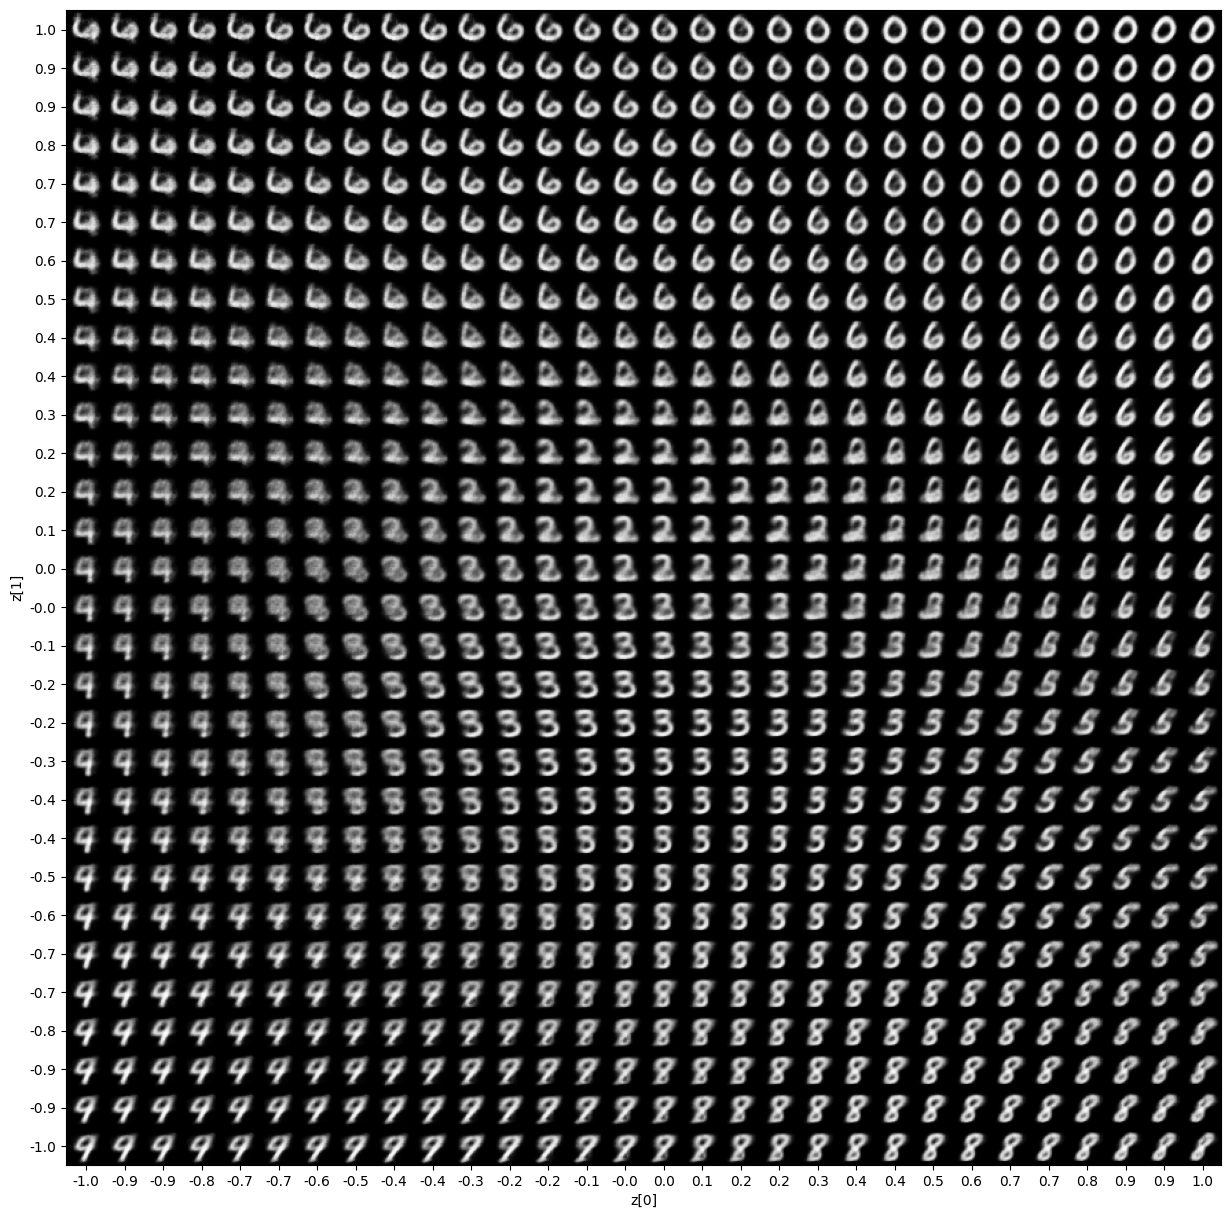

In [7]:
digit_size = 28
scale = 1.0
n = 30
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).to(device, dtype=torch.float)
        x_decoded = model.decoder(z_sample)
        digit = x_decoded[0].detach().cpu().numpy()
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x) 
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()